# Reproduction of results from Prem et al., 2022 (doi: 10.3847/PSJ/ac7ced)

This notebook:
1. Sets up the disort thermal model
2. Produces an enstatite spectrum using the same n,k values and mie code approach as Prem
3. Runs thermal model in steady state to compute thermal profiles
4. Recompute and plot quartz spectra using thermal gradients. 

## Setup and Imports

In [5]:
import sys
import os
from pathlib import Path

# Add parent directory to path for imports
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Import thermal model components
from core.config_manager import ConfigManager, create_default_base_config
from core.thermal_simulation import ThermalSimulator
from modelmain import Simulator
from config import SimulationConfig
from modelmain import fit_blackbody_wn_banded, max_btemp_blackbody, emissionT

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['lines.linewidth'] = 2

print("Imports completed successfully!")

Imports completed successfully!


## Create and Load Base Simulation Configuration

Create and load in a default config file. 

In [3]:
# Option 1: Create a new default configuration
config_path = "../configs/base_configs/analysis_template.yaml"

# Create config directory if it doesn't exist
os.makedirs(os.path.dirname(config_path), exist_ok=True)

# Create default configuration for analysis
create_default_base_config(config_path)

# Load the configuration
config_manager = ConfigManager(config_path)

# Create base configuration
base_config = config_manager.create_config()

print(f"Configuration created at: {config_path}")
print(f"Loaded configuration.")


Default configuration saved to: ../configs/base_configs/analysis_template.yaml
Configuration created at: ../configs/base_configs/analysis_template.yaml
Loaded configuration.


## Run Isothermal Spectrum Simulation



In [4]:
# Modify base configuration for our analysis
analysis_overrides = {
    'diurnal': False,                       # Steady state simulation
    'sun': False,                           # Include solar heating
    'T_fixed': True,                        # Temperature is fixed, prevents thermal evolution
    'compute_observer_radiance': True,      # Compute radiance outputs. 
    'thermal_evolution_mode': 'two_wave',   #Run thermal evolution later with broadband vis (turned off) and broadband thermal. 
    'output_radiance_mode': 'hybrid',       #Compute spectral radiance in thermal only. 
    'observer_mu': 0.5,                     # Observer zenith angle (0 for nadir)
    'Et': 50300.0,                          # Mean extinction coefficient. For phi=0.37, 50300. For phi=0.60, 81600. 
    'ssalb_therm': 0.62,                     # Single scattering albedo for thermal radiation (average from mie code)
    'g_therm': 0.75,                         # Asymmetry parameter for thermal radiation (average from mie code)
    'R_base': 0.0,                          # Global reflectivity value for substrate     
    'disort_space_temp': 0.0,              # Cold shroud temperature
    'k_dust': 4.2e-4,                       # Phonon thermal conductivity of dust (W/m/K)
    'single_layer': True,                   # Use single-layer model
    'dust_thickness': 0.005,                # 10 cm
    'T_bottom': 300,                        # Sample base fixed at 500 K
    'bottom_bc': 'dirichlet',               # Bottom boundary condition (fixed temperature)
    'fill_frac': 0.37,                      #Fill fraction for particles. 
    'radius': 14.e-6,                       #Particle radius in meters.
    'mie_file_out': '/Users/ryan/Research/RT_models/RT_thermal_model/Optical_props/enst_300K_mie_combined.txt',  # Mie file for output
    'wn_bounds_out': '/Users/ryan/Research/RT_models/RT_thermal_model/Optical_props/enst_300k_wn_bounds.txt',  # Wavenumber bounds for output files,
    'nstr_out': 32,                # Number of streams for output
    'nmom_out': 32                # Number of moments for output
}

# Create configuration with overrides
config1 = config_manager.create_config(analysis_overrides)

print("Running baseline simulation...")
print(f"Configuration: Et={config1.Et}, k_dust={config1.k_dust}, thickness={config1.dust_thickness}m")

# Run simulation
sim1 = Simulator(config1)
T_out1, phi_vis1, phi_therm1, T_surf1, t_out1 = sim1.run()

print(f"Simulation completed! Output shape: {T_out1.shape}")
print(f"Time range: {t_out1[0]:.0f} to {t_out1[-1]:.0f} seconds")
print(f"Surface temperature range: {T_surf1.min():.1f} to {T_surf1.max():.1f} K")

Running baseline simulation...
Configuration: Et=50300.0, k_dust=0.00042, thickness=0.005m
Time step: 0.002135 s, Steps per day: 7236476
Thermal evolution mode: two_wave
Output radiance mode: hybrid
Non-diurnal step 0, time=0.00s
Computing DISORT radiance spectra for output.
Computing DISORT emissivity spectra for output.
Radiance calculation completed.
Simulation completed in 1.70 s
Simulation completed! Output shape: (115, 1)
Time range: 0 to 0 seconds
Surface temperature range: 300.0 to 300.0 K


## Plot isothermal spectrum

No temperature gradient, approximate for an ambient lab measurement. 

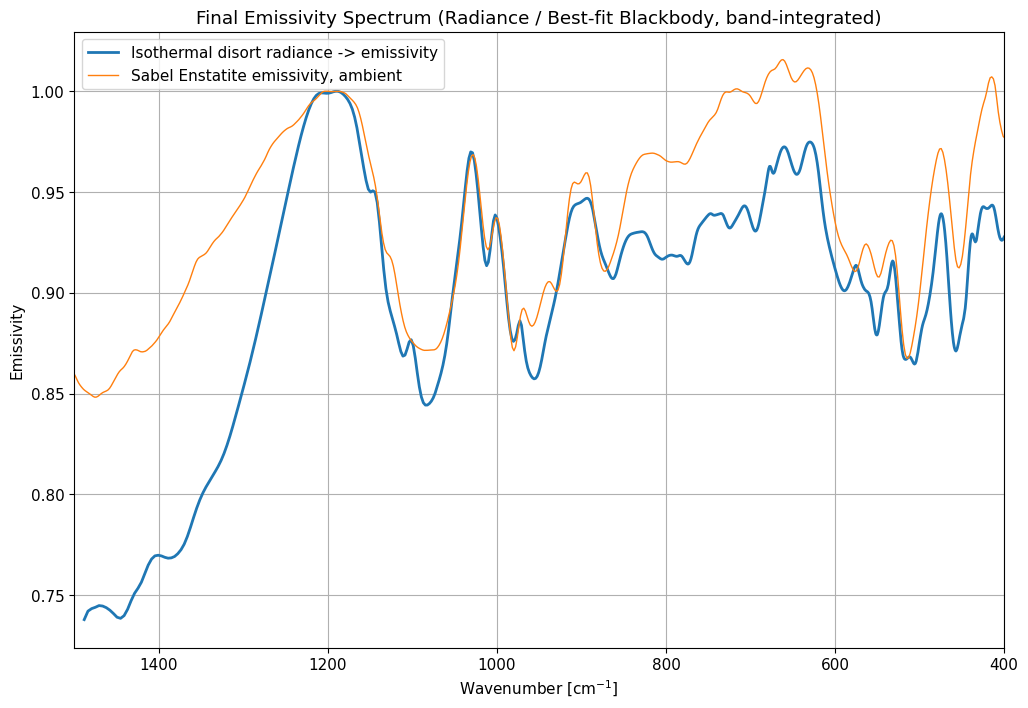

In [ ]:
wn = sim1.wavenumbers_out  # [cm^-1], band centers
final_rad = sim1.radiance_out[:, -1]  # Final time step
ir_cutoff = np.argmin(np.abs(wn - 1500))  # cm^-1, cutoff for IR bands
# Read bin edges from config
wn_bounds = np.sort(np.loadtxt(sim1.cfg.wn_bounds_out))
#T_fit, B_fit, emiss_spec, wn_BB = fit_blackbody_wn_banded(sim,wn_bounds, final_rad)
T_fit, B_fit, btemps, wn_BB = max_btemp_blackbody(sim1,wn_bounds, final_rad)
emiss_spec = final_rad/B_fit
idx1 = np.argmin(np.abs(wn - 900))
idx2 = np.argmin(np.abs(wn - 1700))
ds_cf_emis = emiss_spec[idx1:idx2+1].max()  # Max emissivity in this range
substrate = np.loadtxt('/Users/ryan/Research/RT_models/RT_thermal_model/Optical_props/sabel_enstatite.txt')
idx1 = np.argmin(np.abs(substrate[:,0] - 1700))
idx2 = np.argmin(np.abs(substrate[:,0] - 900))
substrate_cf = substrate[idx1:idx2,1].max()
final_flux = sim1.flux_out[:, -1]  # Final flux at last time step
T_fit_flux, B_fit_flux, btemps_flux, wn_BB_flux = max_btemp_blackbody(sim1, wn_bounds, final_flux/np.pi)
emiss_spec_flux = final_flux/B_fit_flux
idx1 = np.argmin(np.abs(wn - 900))
idx2 = np.argmin(np.abs(wn - 1700))
ds_cf_emis_flux = emiss_spec_flux[idx1:idx2+1].max()  # Max emissivity in this range


plt.figure()
#plt.plot(wn_BB, emiss_spec + otes_cf_emis - bbfit_cf_emis, label=f'Emissivity (T_fit={T_fit:.1f} K)')
#plt.plot(multi_wn_BB, multi_emiss_spec, label=f'Mixture Emissivity (T_fit={multi_T_fit})')
plt.plot(wn[:ir_cutoff], emiss_spec[:ir_cutoff]+1-ds_cf_emis, label=f'Isothermal disort radiance -> emissivity',linewidth=2)
plt.plot(substrate[:,0], substrate[:,1]+1-substrate_cf, label='Sabel Enstatite emissivity, ambient',linewidth=1)
#plt.plot(wn[:ir_cutoff],emiss_spec_flux[:ir_cutoff]+1-ds_cf_emis_flux, label=f'Isothermal disort flux emissivity (T_fit={T_fit_flux:.1f} K)', linestyle='--', linewidth=2)
plt.xlabel('Wavenumber [cm$^{-1}$]')
plt.ylabel('Emissivity')
plt.xlim([400,1500])
plt.title('Final Emissivity Spectrum (Radiance / Best-fit Blackbody, band-integrated)')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()

## Run thermal evolution model for lunar environmental chamber conditions. 



In [15]:

# Allow thermal evolution now. 
analysis_overrides['T_fixed'] = False
analysis_overrides['steady_tol'] = 1.5e-2  # Convergence tolerance for steady state (K)
config2 = config_manager.create_config(analysis_overrides)

# Run simulation
sim2 = Simulator(config2)
T_out2, phi_vis2, phi_therm2, T_surf2, t_out2 = sim2.run()

print(f"Simulation completed! Output shape: {T_out1.shape}")
print(f"Time range: {t_out1[0]:.0f} to {t_out1[-1]:.0f} seconds")
print(f"Surface temperature range: {T_surf1.min():.1f} to {T_surf1.max():.1f} K")

Time step: 0.002135 s, Steps per day: 7236476
Thermal evolution mode: two_wave
Output radiance mode: hybrid
Non-diurnal step 0, time=0.00s
[Steady-state check] step 200, max |T - T_ext| = 1.272e+00 K
[Steady-state check] step 400, max |T - T_ext| = 9.055e-01 K
[Steady-state check] step 600, max |T - T_ext| = 7.336e-01 K
[Steady-state check] step 800, max |T - T_ext| = 6.371e-01 K
[Steady-state check] step 1000, max |T - T_ext| = 5.519e-01 K
Non-diurnal step 1000, time=2.14s
[Steady-state check] step 1200, max |T - T_ext| = 4.769e-01 K
[Steady-state check] step 1400, max |T - T_ext| = 4.447e-01 K
[Steady-state check] step 1600, max |T - T_ext| = 4.141e-01 K
[Steady-state check] step 1800, max |T - T_ext| = 3.853e-01 K
[Steady-state check] step 2000, max |T - T_ext| = 3.584e-01 K
Non-diurnal step 2000, time=4.27s
[Steady-state check] step 2200, max |T - T_ext| = 3.332e-01 K
[Steady-state check] step 2400, max |T - T_ext| = 3.096e-01 K
[Steady-state check] step 2600, max |T - T_ext| = 2.8

## Plot vacuum thermal gradient

In [ ]:
plt.plot(T_out2[1:,-1]-sim2.cfg.T_bottom ,sim2.grid.x[1:]/sim2.cfg.Et * 1e6)
plt.ylabel('Depth into medium [µm]')
plt.xlabel('Temperature Difference [K]')
plt.ylim([0,1000])
#plt.legend(loc='upper right')
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

plt.semilogy(T_out2[1:,-1]-sim2.cfg.T_bottom ,sim2.grid.x[1:]/sim2.cfg.Et)
plt.ylabel('Depth into medium [m]')
plt.xlabel('Temperature Difference [K]')
#plt.legend(loc='upper right')
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

## Plot vacuum spectrum

In [ ]:
final_rad2 = sim2.radiance_out[:, -1]  # Final time step
T_fit, B_fit, btemps, wn_BB = max_btemp_blackbody(sim2,wn_bounds, final_rad2)
emiss_spec2 = final_rad2/B_fit
idx1 = np.argmin(np.abs(wn - 900))
idx2 = np.argmin(np.abs(wn - 1700))
ds_cf_emis2 = emiss_spec2[idx1:idx2+1].max()  # Max emissivity in this range

final_flux2 = sim2.flux_out[:, -1]  # Final flux at last time step
T_fit_flux, B_fit_flux, btemps_flux, wn_BB_flux = max_btemp_blackbody(sim2, wn_bounds, final_flux/np.pi)
emiss_spec_flux2 = final_flux/B_fit_flux
idx1 = np.argmin(np.abs(wn - 900))
idx2 = np.argmin(np.abs(wn - 1700))
ds_cf_emis_flux2 = emiss_spec_flux2[idx1:idx2+1].max()  # Max emissivity in this range


plt.figure()
plt.plot(wn[:ir_cutoff], emiss_spec[:ir_cutoff]+1-ds_cf_emis, label=f'Isothermal',linewidth=2)
#plt.plot(wn[:ir_cutoff],emiss_spec_flux[:ir_cutoff]+1-ds_cf_emis_flux, label=f'Isothermal flux)', linestyle='--',linewidth=2)
plt.plot(wn[:ir_cutoff], emiss_spec2[:ir_cutoff]+1-ds_cf_emis2, label=f'Vacuum',linewidth=2)
#plt.plot(wn[:ir_cutoff],emiss_spec_flux2[:ir_cutoff]+1-ds_cf_emis_flux2, label=f'Vacuum flux)', linestyle='--', linewidth=2)
plt.xlabel('Wavenumber [cm$^{-1}$]')
plt.ylabel('Emissivity')
plt.title('Final Emissivity Spectrum (Radiance / Best-fit Blackbody, band-integrated)')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()

plt.figure()
plt.plot(10000./wn[:ir_cutoff], emiss_spec[:ir_cutoff]+1-ds_cf_emis, label=f'Isothermal',linewidth=2)
#plt.plot(10000./wn[:ir_cutoff],emiss_spec_flux[:ir_cutoff]+1-ds_cf_emis_flux, label=f'Isothermal flux)', linestyle='--',linewidth=2)
plt.plot(10000./wn[:ir_cutoff], emiss_spec2[:ir_cutoff]+1-ds_cf_emis2, label=f'Vacuum',linewidth=2)
#plt.plot(10000./wn[:ir_cutoff],emiss_spec_flux2[:ir_cutoff]+1-ds_cf_emis_flux2, label=f'Vacuum flux)', linestyle='--', linewidth=2)
plt.xlabel('Wavelength [µm]')
plt.ylabel('Emissivity')
plt.title('Final Emissivity Spectrum (Radiance / Best-fit Blackbody, band-integrated)')
plt.xlim([6,14])
plt.legend()
plt.grid(True)
plt.show()